# Comparison between the HAT Mask Regularization and Gradient Compensation

This notebook compares the effects between HAT mask regularization factor and gradient compensation factor.
Both factors alter the gradients of the HAT mask attention parameters, but in different ways.
- Regularization factor (`strat=uniform`): regularize the HAT mask attention by penalizing additional mask usage of the current task.
- Gradient compensation factor: compensate the gradient of the HAT mask attention by multiplying the gradient with the factor.

## Prepare the Dataset and Network

First, we prepare the dataset and network.
We plan to use MNIST dataset and a simple linear network for this experiment.

In [1]:
from pathlib import Path

import torch
import torchvision
import torch.nn as nn

from hat.modules import HATLinear
from hat import HATConfig, HATPayload


example_dir_path = Path().resolve()
data_dir_path = Path.joinpath(example_dir_path, "data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create MNIST datasets and dataloaders
trn_dataset = torchvision.datasets.MNIST(
    root=data_dir_path,
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
tst_dataset = torchvision.datasets.MNIST(
    root=data_dir_path,
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
trn_dataloader = torch.utils.data.DataLoader(
    trn_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True if device.type == "cuda" else False,
    num_workers=4 if device.type == "cuda" else 0,
)
tst_dataloader = torch.utils.data.DataLoader(
    tst_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True if device.type == "cuda" else False,
    num_workers=4 if device.type == "cuda" else 0,
)


class LinearNet(nn.Module):
    def __init__(self, hat_grad_comp_factor):
        super().__init__()
        self.hat_config = HATConfig(
            num_tasks=1,
            init_strat="dense",
            grad_comp_factor=hat_grad_comp_factor,
        )
        self.fc1 = HATLinear(
            in_features=784,
            out_features=128,
            hat_config=self.hat_config,
        )
        self.fc2 = nn.Linear(
            in_features=128,
            out_features=10,
        )

    def forward(self, pld: HATPayload):
        pld = self.fc1(pld)
        data = torch.relu(pld.data)
        return self.fc2(data)

## Define the Training and Evaluation Functions

In [2]:
from hat.utils import get_hat_mask_scale, get_hat_reg_term

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(
    num_epochs: int,
    hat_reg_factor: float,
    hat_grad_comp_factor: float,
    optimizer: str,
    learning_rate: float,
) -> nn.Module:
    model = LinearNet(hat_grad_comp_factor)
    model = model.to(device)
    model.train()

    if optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    for _ in range(num_epochs):
        for __i, (__images, __targets) in enumerate(trn_dataloader):
            optimizer.zero_grad()
            __images = __images.view(-1, 784).to(device)
            __targets = __targets.to(device)
            __progress = __i / (len(trn_dataloader) - 1)
            __mask_scale = get_hat_mask_scale(
                strat="cosine",
                max_trn_mask_scale=model.hat_config.max_trn_mask_scale,
                progress=__progress,
            )
            __pld = HATPayload(
                data=__images,
                task_id=0,
                mask_scale=__mask_scale,
            )
            __logits = model(__pld)
            __loss = nn.functional.cross_entropy(__logits, __targets)
            __reg = get_hat_reg_term(
                module=model,
                strat="uniform",
                task_id=0,
                mask_scale=__mask_scale,
                forgive_quota=False,
            )
            __loss += hat_reg_factor * __reg
            __loss.backward()
            optimizer.step()

    return model


def evaluate(model: nn.Module) -> float:
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for __images, __targets in tst_dataloader:
            __images = __images.view(-1, 784).to(device)
            __targets = __targets.to(device)
            __pld = HATPayload(
                data=__images,
                task_id=0,
                mask_scale=1.0,
            )
            __logits = model(__pld)
            __predicted = torch.argmax(__logits, dim=1)
            total += __targets.size(0)
            correct += (__predicted == __targets).sum().item()
    return correct / total

## Define the Experiment Function

The experiment function trains the model with the given hyperparameters and evaluates the model, over different regularization factors and gradient compensation factors.

After the experiment, the results are plotted in a heatmap.

In [3]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def experiment(
    num_epochs_per_trail: int,
    num_trails_per_args: int,
    optimizer: str,
    learning_rate: float,
) -> np.ndarray:
    hat_reg_factors = np.linspace(start=0, stop=5, num=num_trails_per_args)
    hat_grad_comp_factors = np.linspace(
        start=10, stop=200, num=num_trails_per_args
    )
    args_combo = list(
        itertools.product(hat_reg_factors, hat_grad_comp_factors)
    )

    accs, mask_utils = [], []
    for __args in tqdm(args_combo):
        __hat_reg_factor, __hat_grad_comp_factor = __args
        __model = train(
            num_epochs=num_epochs_per_trail,
            hat_reg_factor=__hat_reg_factor,
            hat_grad_comp_factor=__hat_grad_comp_factor,
            optimizer=optimizer,
            learning_rate=learning_rate,
        )
        accs.append(evaluate(__model))
        mask_utils.append(
            __model.fc1.masker.get_binary_mask(0).data.cpu().float().mean()
        )

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    for i, z in enumerate([accs, mask_utils]):
        c = ax[i].pcolor(
            hat_grad_comp_factors,
            hat_reg_factors,
            np.array(z).reshape(num_trails_per_args, num_trails_per_args),
            cmap="RdBu",
        )
        ax[i].set_xticks(hat_grad_comp_factors)
        ax[i].set_yticks(hat_reg_factors)
        ax[i].set_xlabel("Gradient Compensation Factor")
        ax[i].set_ylabel("Regularization Factor")
        fig.colorbar(c, ax=ax[i])
    ax[0].set_title("Accuracy")
    ax[1].set_title("Mask Utilization")
    fig.suptitle(
        f"Trained with {optimizer} (lr={learning_rate}, epochs={num_epochs_per_trail})"
    )
    plt.show()

## Run the Experiment

Now let's investigate the effect of the gradient compensation factor on the accuracy and mask utilization with different optimizers (SGD with learning rate 0.01 and Adam with learning rate 0.001).

100%|██████████| 100/100 [12:34<00:00,  7.54s/it]


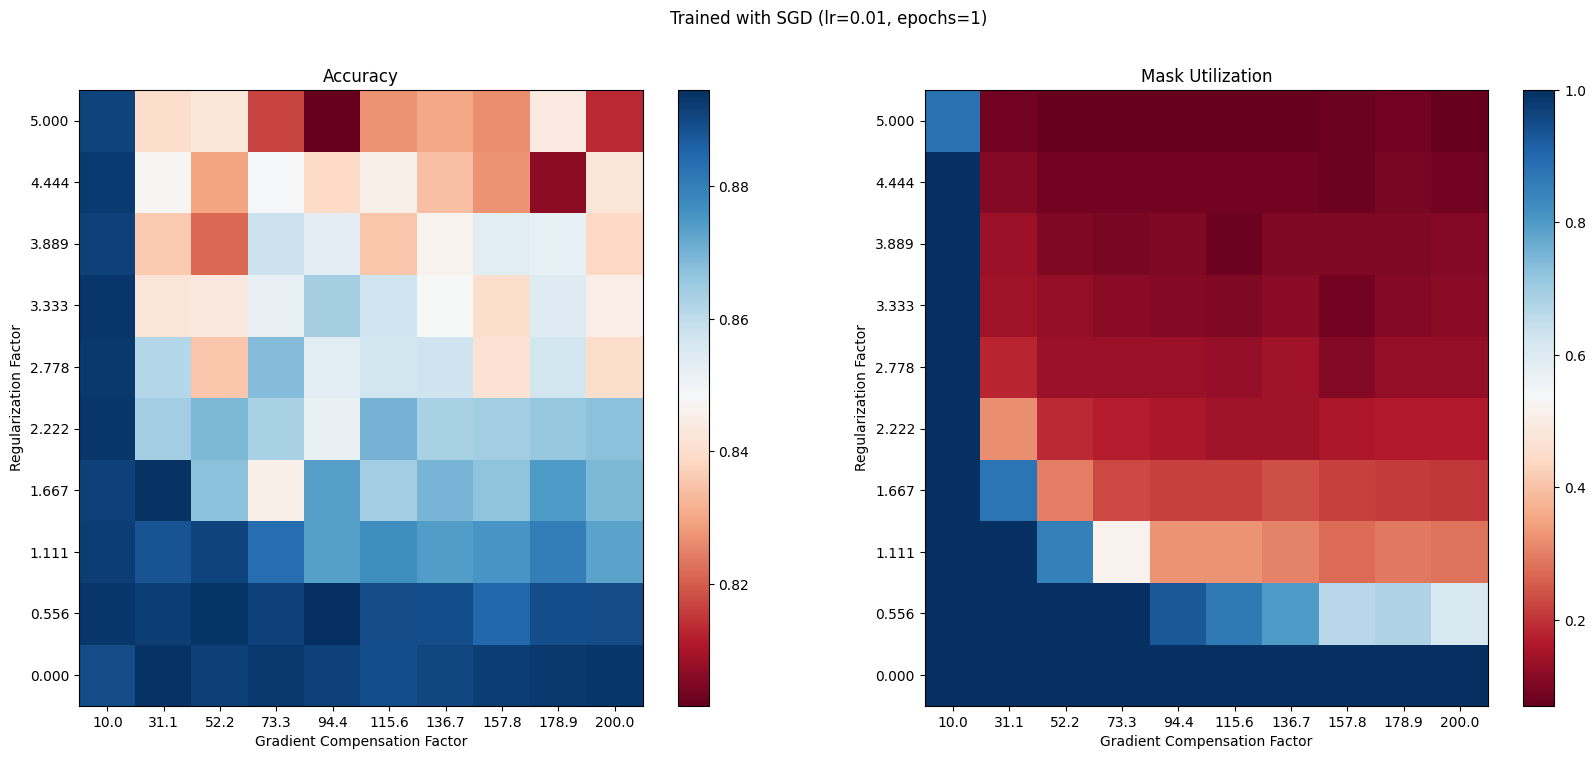

In [4]:
experiment(
    num_epochs_per_trail=1,
    num_trails_per_args=10,
    optimizer="SGD",
    learning_rate=0.01,
)

100%|██████████| 100/100 [14:16<00:00,  8.57s/it]


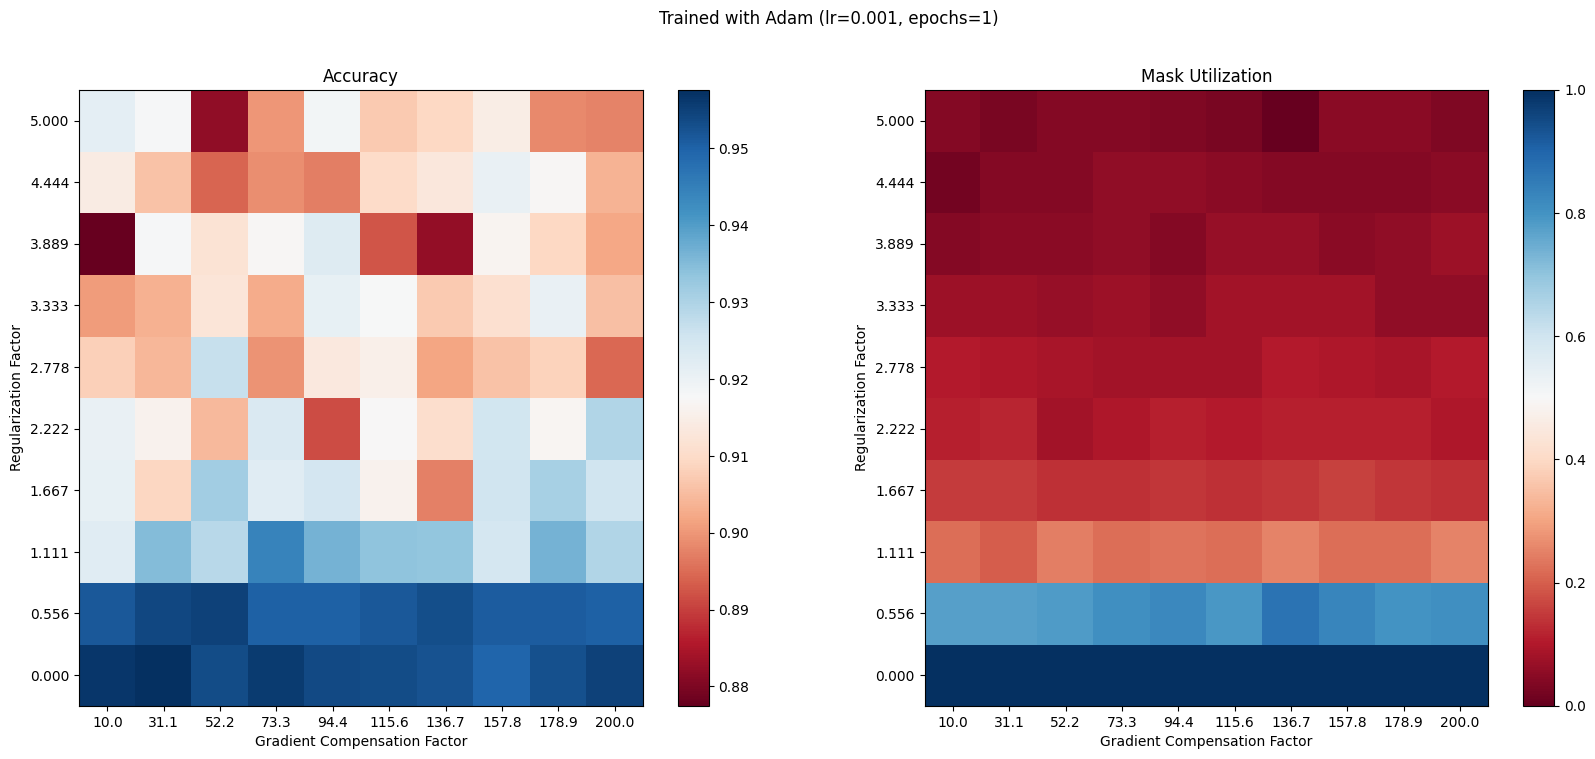

In [5]:
experiment(
    num_epochs_per_trail=1,
    num_trails_per_args=10,
    optimizer="Adam",
    learning_rate=0.001,
)

## Conclusion

The results demonstrated that the regularization factor and the gradient compensation factor have similar effect on the HAT regularization when trained with an SGD optimizer, as they both accelerate and amplify the regularization effect.
However, when adaptive optimizers, such as Adam, are used, the gradient compensation factor becomes obsolete, as the adaptive optimizers can automatically adjust the learning rate for each parameter.
Therefore, when using adaptive optimizers, the regularization factor should be used to control the regularization effect.